In [40]:
import h5py 
import numpy as np
import os 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import matplotlib.colors as mcolors 
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

use_tex = 1
plt.rcParams['text.usetex'] = use_tex
matplotlib.rcParams['font.size'] = 14         # overall font size
matplotlib.rcParams['axes.titlesize'] = 14    # size of the axes title
matplotlib.rcParams['axes.labelsize'] = 14    # size of the axis labels
matplotlib.rcParams['xtick.labelsize'] = 12   # size of the x-axis tick labels
matplotlib.rcParams['ytick.labelsize'] = 12   # size of the y-axis tick labels

plt.rcParams['figure.facecolor'] = '#ffffff'  
plt.rcParams['axes.facecolor'] = '#fafafa' 
plt.rcParams['axes.labelcolor'] = '222222'  
plt.rcParams['axes.titlecolor'] = '#000000' 
plt.rcParams['xtick.color'] = '#444444'  
plt.rcParams['ytick.color'] = '#444444'
plt.rcParams['legend.edgecolor'] = '#666666'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['grid.color'] = '#cccccc' 

cmp = cm.viridis 
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_viridis', cmp(np.linspace(0.0, 0.98, 256)))
colors = [cmap(0.0), cmap(0.5), cmap(0.9)]

# Plot the Subspace 

99.9013440587874


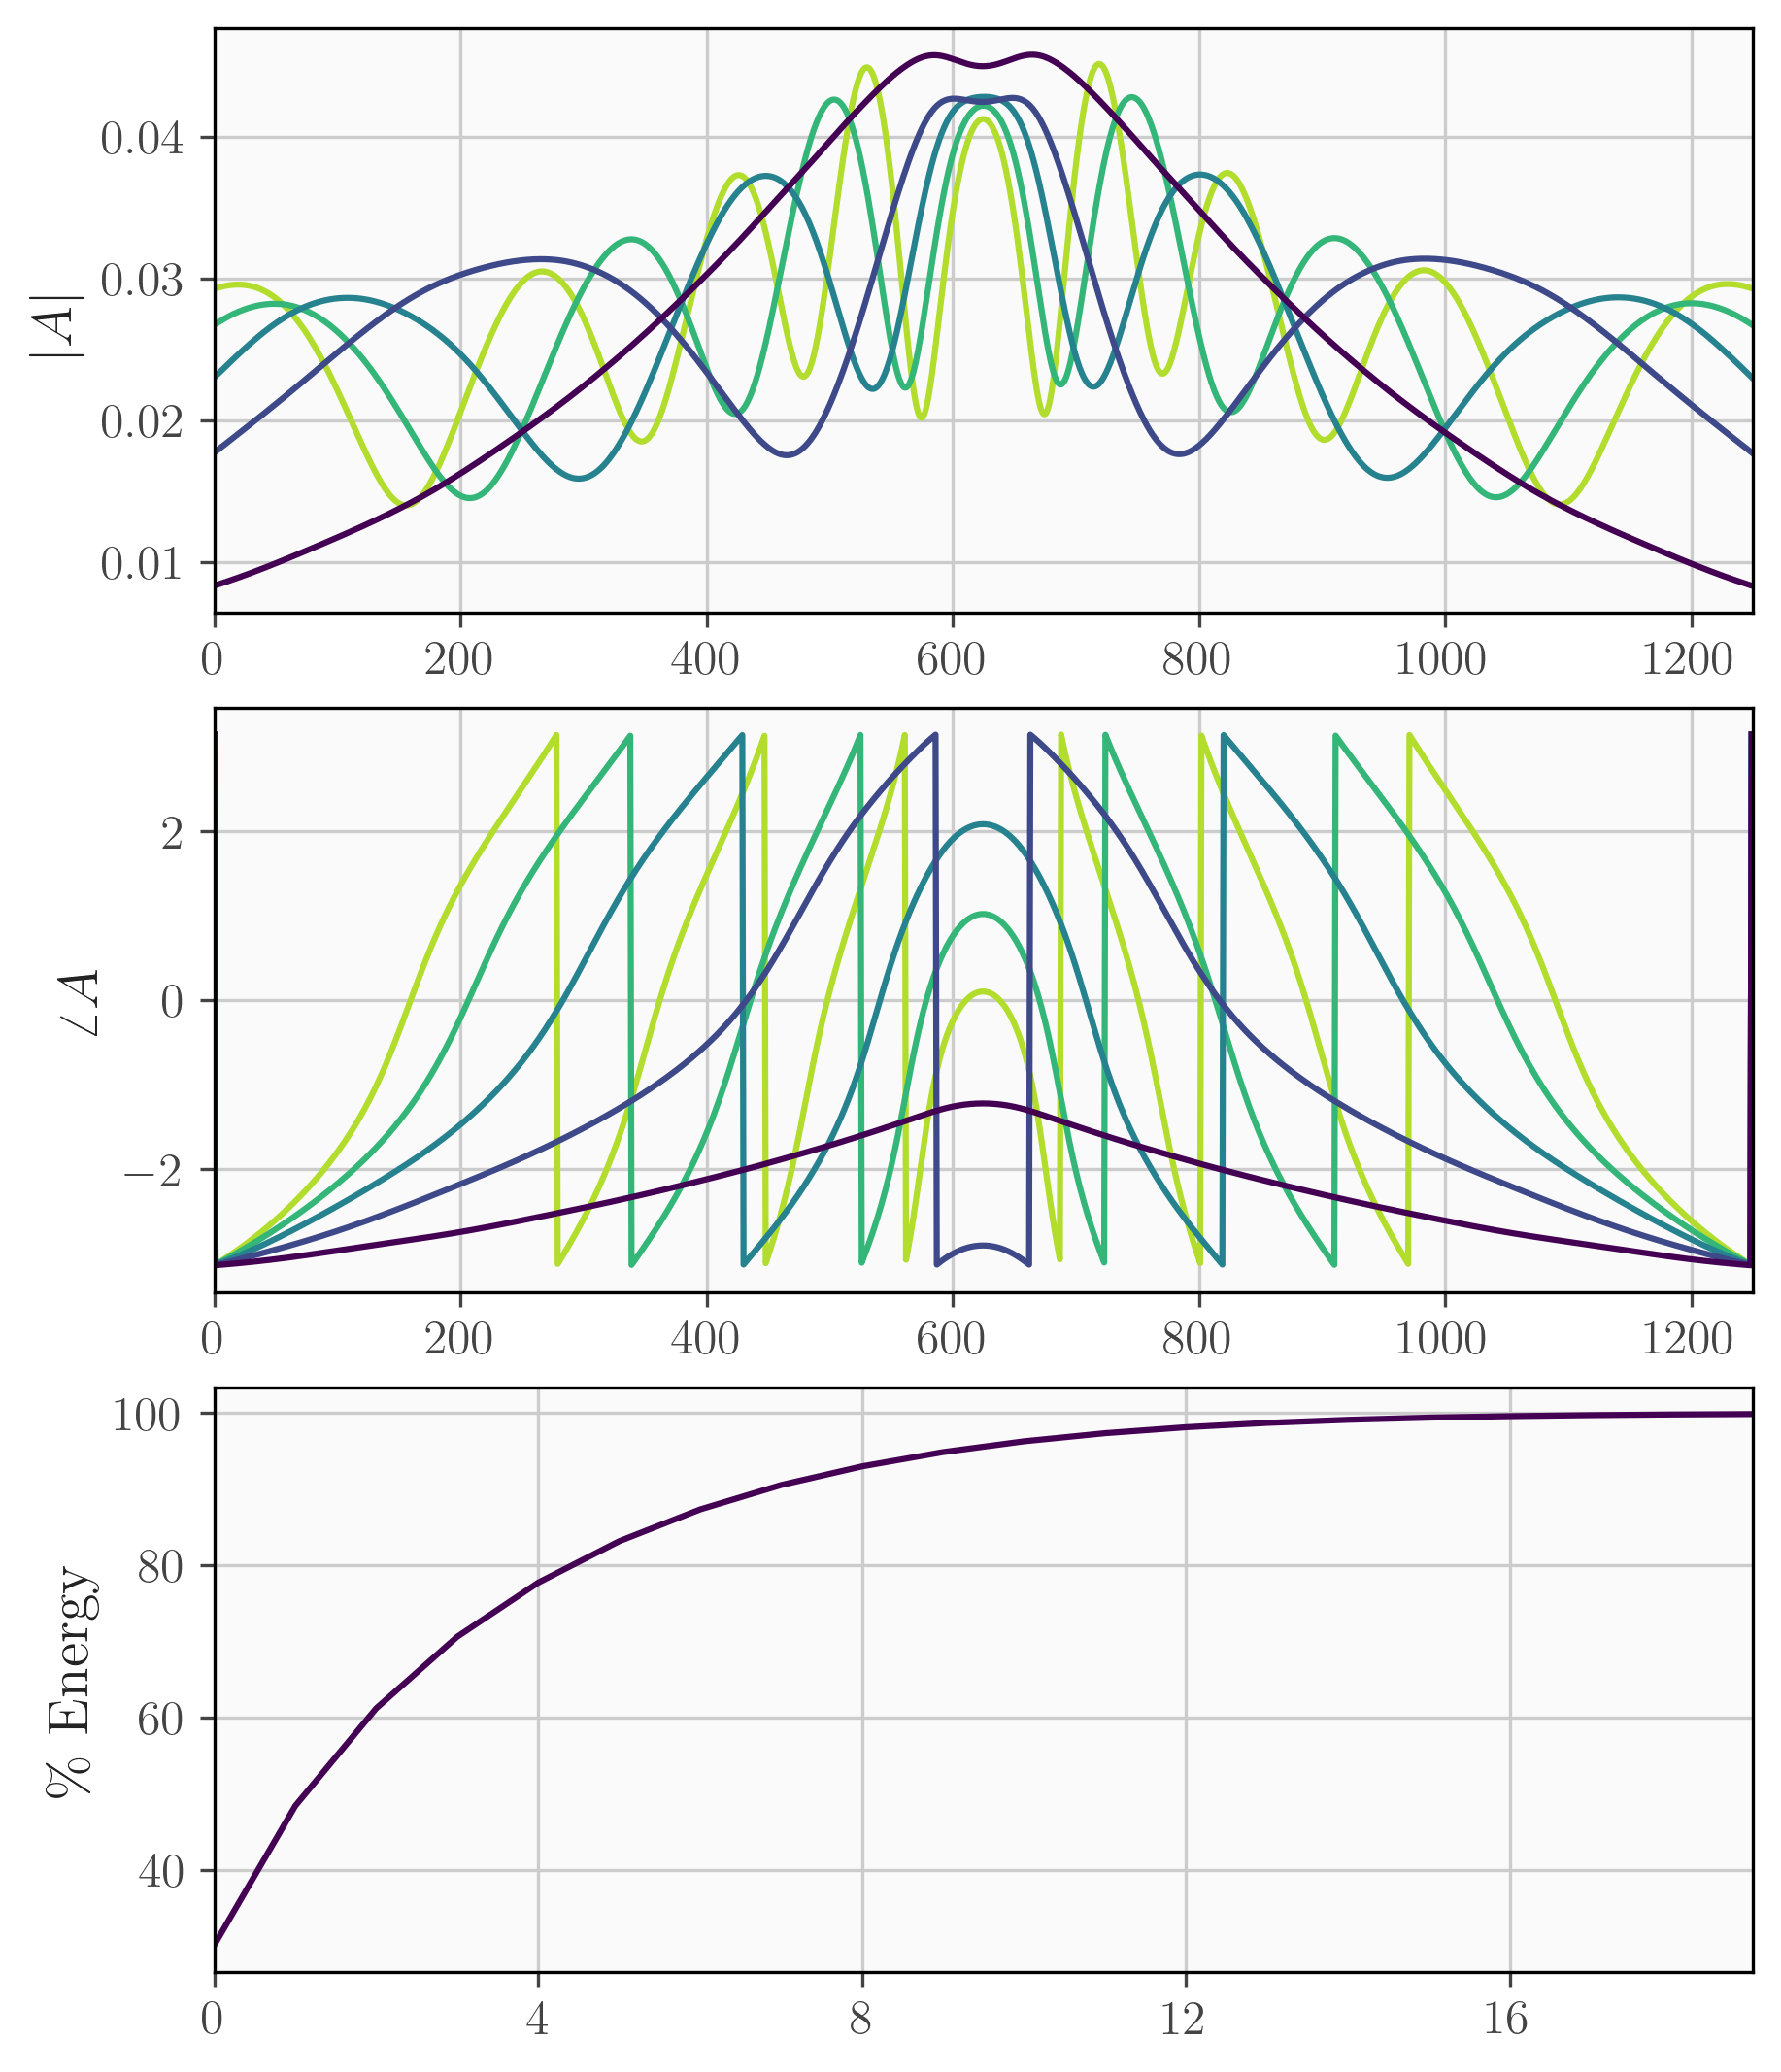

In [41]:
data_dir = 'data/sel_20250313_073618/'
data_file = os.path.join(data_dir, 'pulse_000.h5')

rank_plot = 5
rank = 20
basis_colors = cmap(np.linspace(0.0, 0.9, rank_plot))

with h5py.File(data_file,'r') as F:
    basis = np.array(F['basis'], dtype=np.complex128)
    s = np.array(F['s'], dtype=np.float64)
cumulative_energy = 100*np.cumsum(s)/np.sum(s)
print(cumulative_energy[rank])

fig,ax = plt.subplots(3, 1, figsize=(6,7), dpi=300, constrained_layout=True)
for b in range(rank_plot-1,-1,-1):
    ax[0].plot(np.abs(basis[:,b]), color=basis_colors[b])
    ax[0].set_xlim(0, basis.shape[0])
    ax[1].plot(np.angle(basis[:,b]), color=basis_colors[b])
    ax[1].set_xlim(0, basis.shape[0])
ax[0].grid()
ax[0].set_ylabel(r'$|A|$')
ax[1].grid()
ax[1].set_ylabel(r'$\angle{A}$')
ax[2].plot(cumulative_energy[:rank], color=basis_colors[0])
ax[2].set_xlim(0, rank-1)
ax[2].set_ylabel(r'$\mathrm{\%\ Energy}$')
ax[2].set_xticks(np.arange(0, rank, 4))
ax[2].grid()

figfile = os.path.join(data_dir, 'figure_subspace_%d.png'%(use_tex))
plt.savefig(figfile)
plt.show()


# Selective Inversion: Peak $B_1$ and Energy Reduction

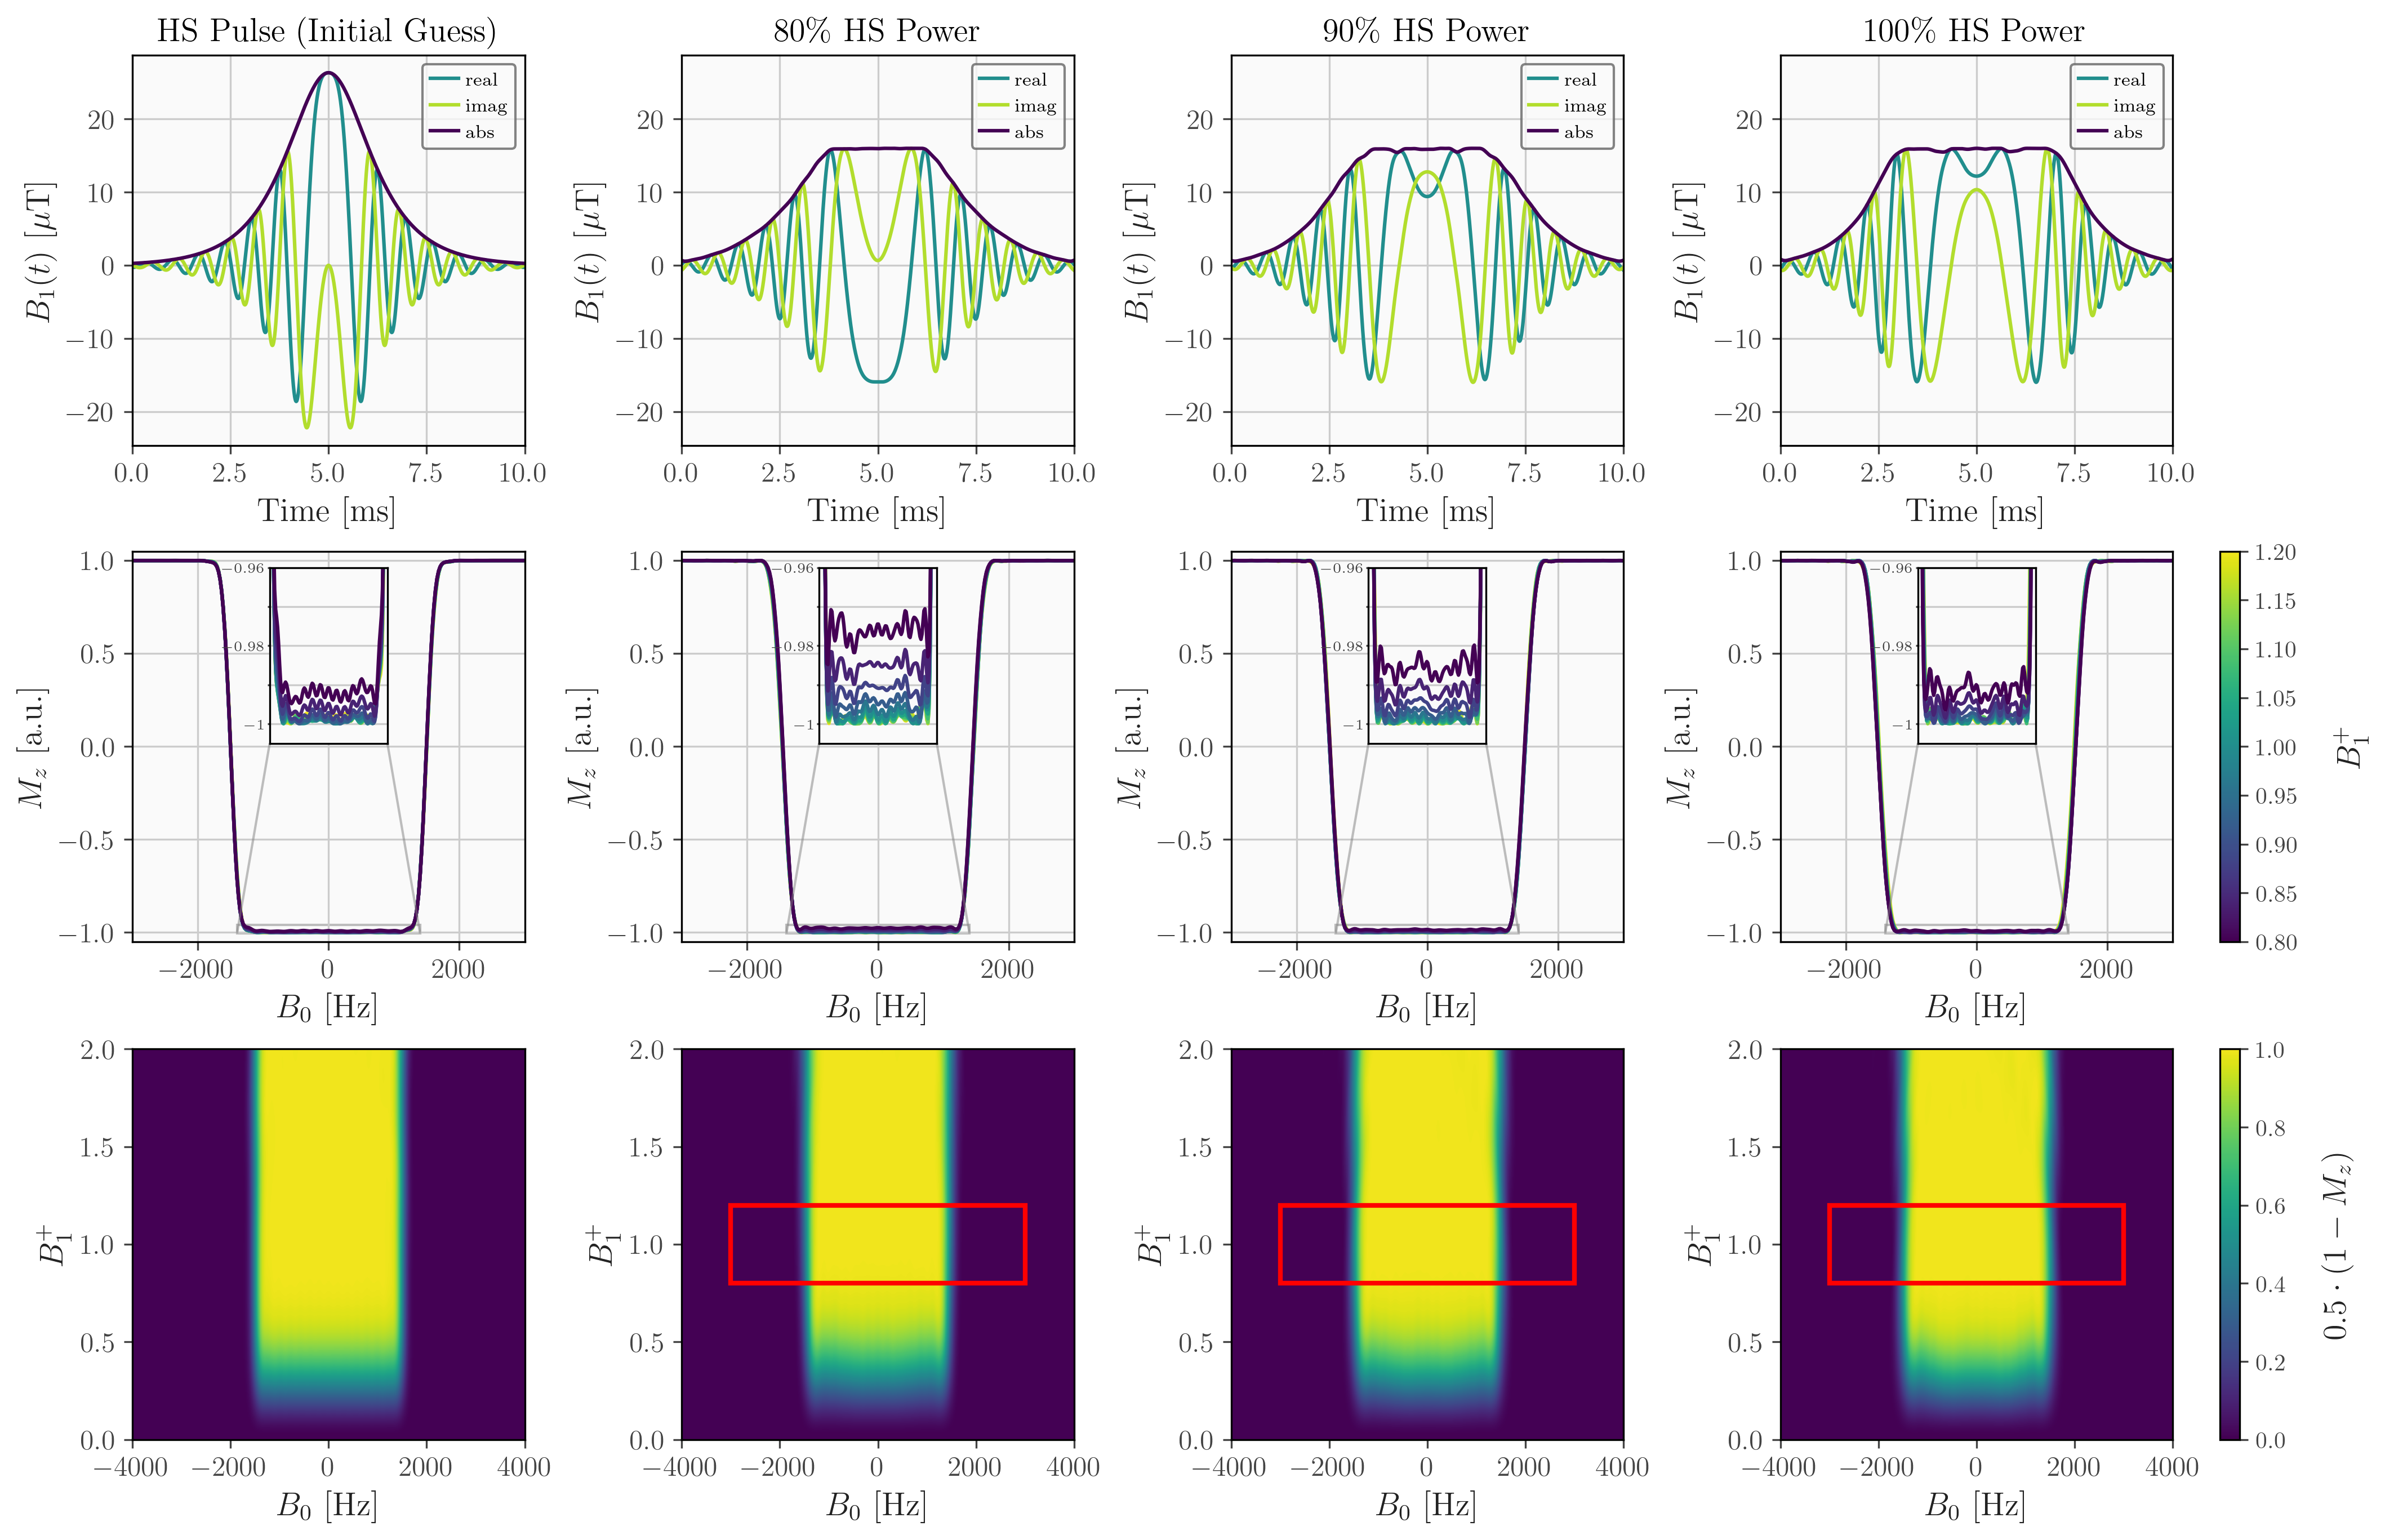

In [42]:
data_dir = 'data/sel_20250313_073618'
data_file = os.path.join(data_dir, 'eval_data.h5')

with h5py.File(data_file,'r') as F:
    num_pulses = F['num_pulses'][()]
    b1_design = np.array(F['b1_design'], dtype=np.float64)
    freq_design = np.array(F['freq_design'], dtype=np.float64)
    b1_eval = np.array(F['b1_eval'], dtype=np.float64)
    freq_eval = np.array(F['freq_eval'], dtype=np.float64)

    color_indices = np.linspace(0.0, 1.0, b1_design.size)
    norm = mcolors.Normalize(vmin=b1_design.min(), vmax=b1_design.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig,ax = plt.subplots(3, num_pulses, figsize=(14,9), dpi=300, constrained_layout=True)

    for p in range(num_pulses):

        rf = np.array(F['pulse_%i'%(p)], dtype=np.complex128)
        tv = np.array(F['tv_%i'%(p)], dtype=np.float64)
        dur = F['dur_%i'%(p)][()]
        mz = np.array(F['mz_%i'%(p)], dtype=np.float64)
        mz_eval = np.transpose(np.array(F['mz_eval_%i'%(p)], dtype=np.float64), (1,0))
        show_optimized_region = F['show_optimized_region_%i'%(p)][()]
        x_corner = F['x_corner_%i'%(p)][()]
        y_corner = F['y_corner_%i'%(p)][()]
        width = F['width_%i'%(p)][()]
        height = F['height_%i'%(p)][()]
        title = F['title_%i'%(p)][()].decode("utf-8")
        legend_loc = F['legend_loc_%i'%(p)][()].decode("utf-8")

        ax[0,p].plot(tv, np.real(rf), color=colors[1], label=r'$\mathrm{real}$')
        ax[0,p].plot(tv, np.imag(rf), color=colors[2], label=r'$\mathrm{imag}$')
        ax[0,p].plot(tv, np.abs(rf), color=colors[0], label=r'$\mathrm{abs}$')
        ax[0,p].set_ylabel(r'$B_1(t)\mathrm{\ [}\mu\mathrm{T]}$')
        ax[0,p].set_xlabel(r'$\mathrm{Time\ [ms]}$')
        ax[0,p].set_xlim(0, dur)
        if p > 0:
            ax[0,p].set_ylim(ax[0,0].get_ylim())
        ax[0,p].grid()
        ax[0,p].legend(loc=legend_loc, fontsize=8, handlelength=1.5, handletextpad=0.4)
        ax[0,p].set_title(r'%s'%(title))

        for n in range(mz.shape[1]-1,-1,-1):
            ax[1,p].plot(freq_design, mz[:,n], color=cmap(color_indices[n]), label=r'$B_1^+=%.2f$'%(b1_design[n]))
        #ax[1,p].set_xlabel(r'$\mathrm{Off-Resonance\ [Hz]}$')
        ax[1,p].set_xlabel(r'$B_0\mathrm{\ [Hz]}$')
        ax[1,p].set_ylabel(r'$M_z\mathrm{\ [a.u.]}$')
        ax[1,p].set_xlim(freq_design.min(), freq_design.max())
        ax[1,p].set_ylim(-1.05, 1.05)
        ax[1,p].grid()

        inax = inset_axes(ax[1,p], width='30%', height='45%', loc='upper center')
        for n in range(mz.shape[1]-1,-1,-1):
            inax.plot(freq_design, mz[:,n], color=cmap(color_indices[n]), label=r'$B_1^+=%.2f$'%(b1_design[n]))
        inax.set_xlim(-1400, 1400)
        inax.set_ylim(-1.005, -0.96)
        inax.tick_params(axis='x', labelsize=6)
        inax.tick_params(axis='y', labelsize=6, pad=0.25, length=1)
        inax.set_yticks([-1, -0.99, -0.98, -0.97, -0.96])
        inax.set_yticklabels([r'$-1$', '', r'$-0.98$', '', r'$-0.96$'])
        inax.set_xticks([])
        inax.set_xticklabels([])
        inax.grid()
        mark_inset(ax[1,p], inax, loc1=3, loc2=4, ec='gray', alpha=0.5)

        img = ax[2,p].imshow((1-mz_eval)/2, vmin=0.0, vmax=1.0, cmap=cmap, extent=[freq_eval.min(), freq_eval.max(), b1_eval.min(), b1_eval.max()], origin='lower')
        ax[2,p].set_aspect('auto')
        ax[2,p].set_ylabel(r'$B_1^+$')
        #ax[2,p].set_xlabel(r'$\mathrm{Off-Resonance\ [Hz]}$')
        ax[2,p].set_xlabel(r'$B_0\mathrm{\ [Hz]}$')
        if show_optimized_region:
            rect = matplotlib.patches.Rectangle((x_corner, y_corner), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax[2,p].add_patch(rect)
        
    cbar1 = fig.colorbar(sm, ax=ax[1,-1])
    cbar1.ax.tick_params(labelsize=10)
    cbar1.set_label(r'$B_1^+$', labelpad=15)

    cbar2 = fig.colorbar(img, ax=ax[2,-1])
    cbar2.ax.tick_params(labelsize=10)
    cbar2.set_label(r'$0.5\cdot (1 - M_z)$', labelpad=15)

    figfile = os.path.join(data_dir, 'figure_selective_%d.png'%(use_tex))
    plt.savefig(figfile)
    plt.show()

# Non-Selective Inversion w/ Comparison to Graf et. al. 

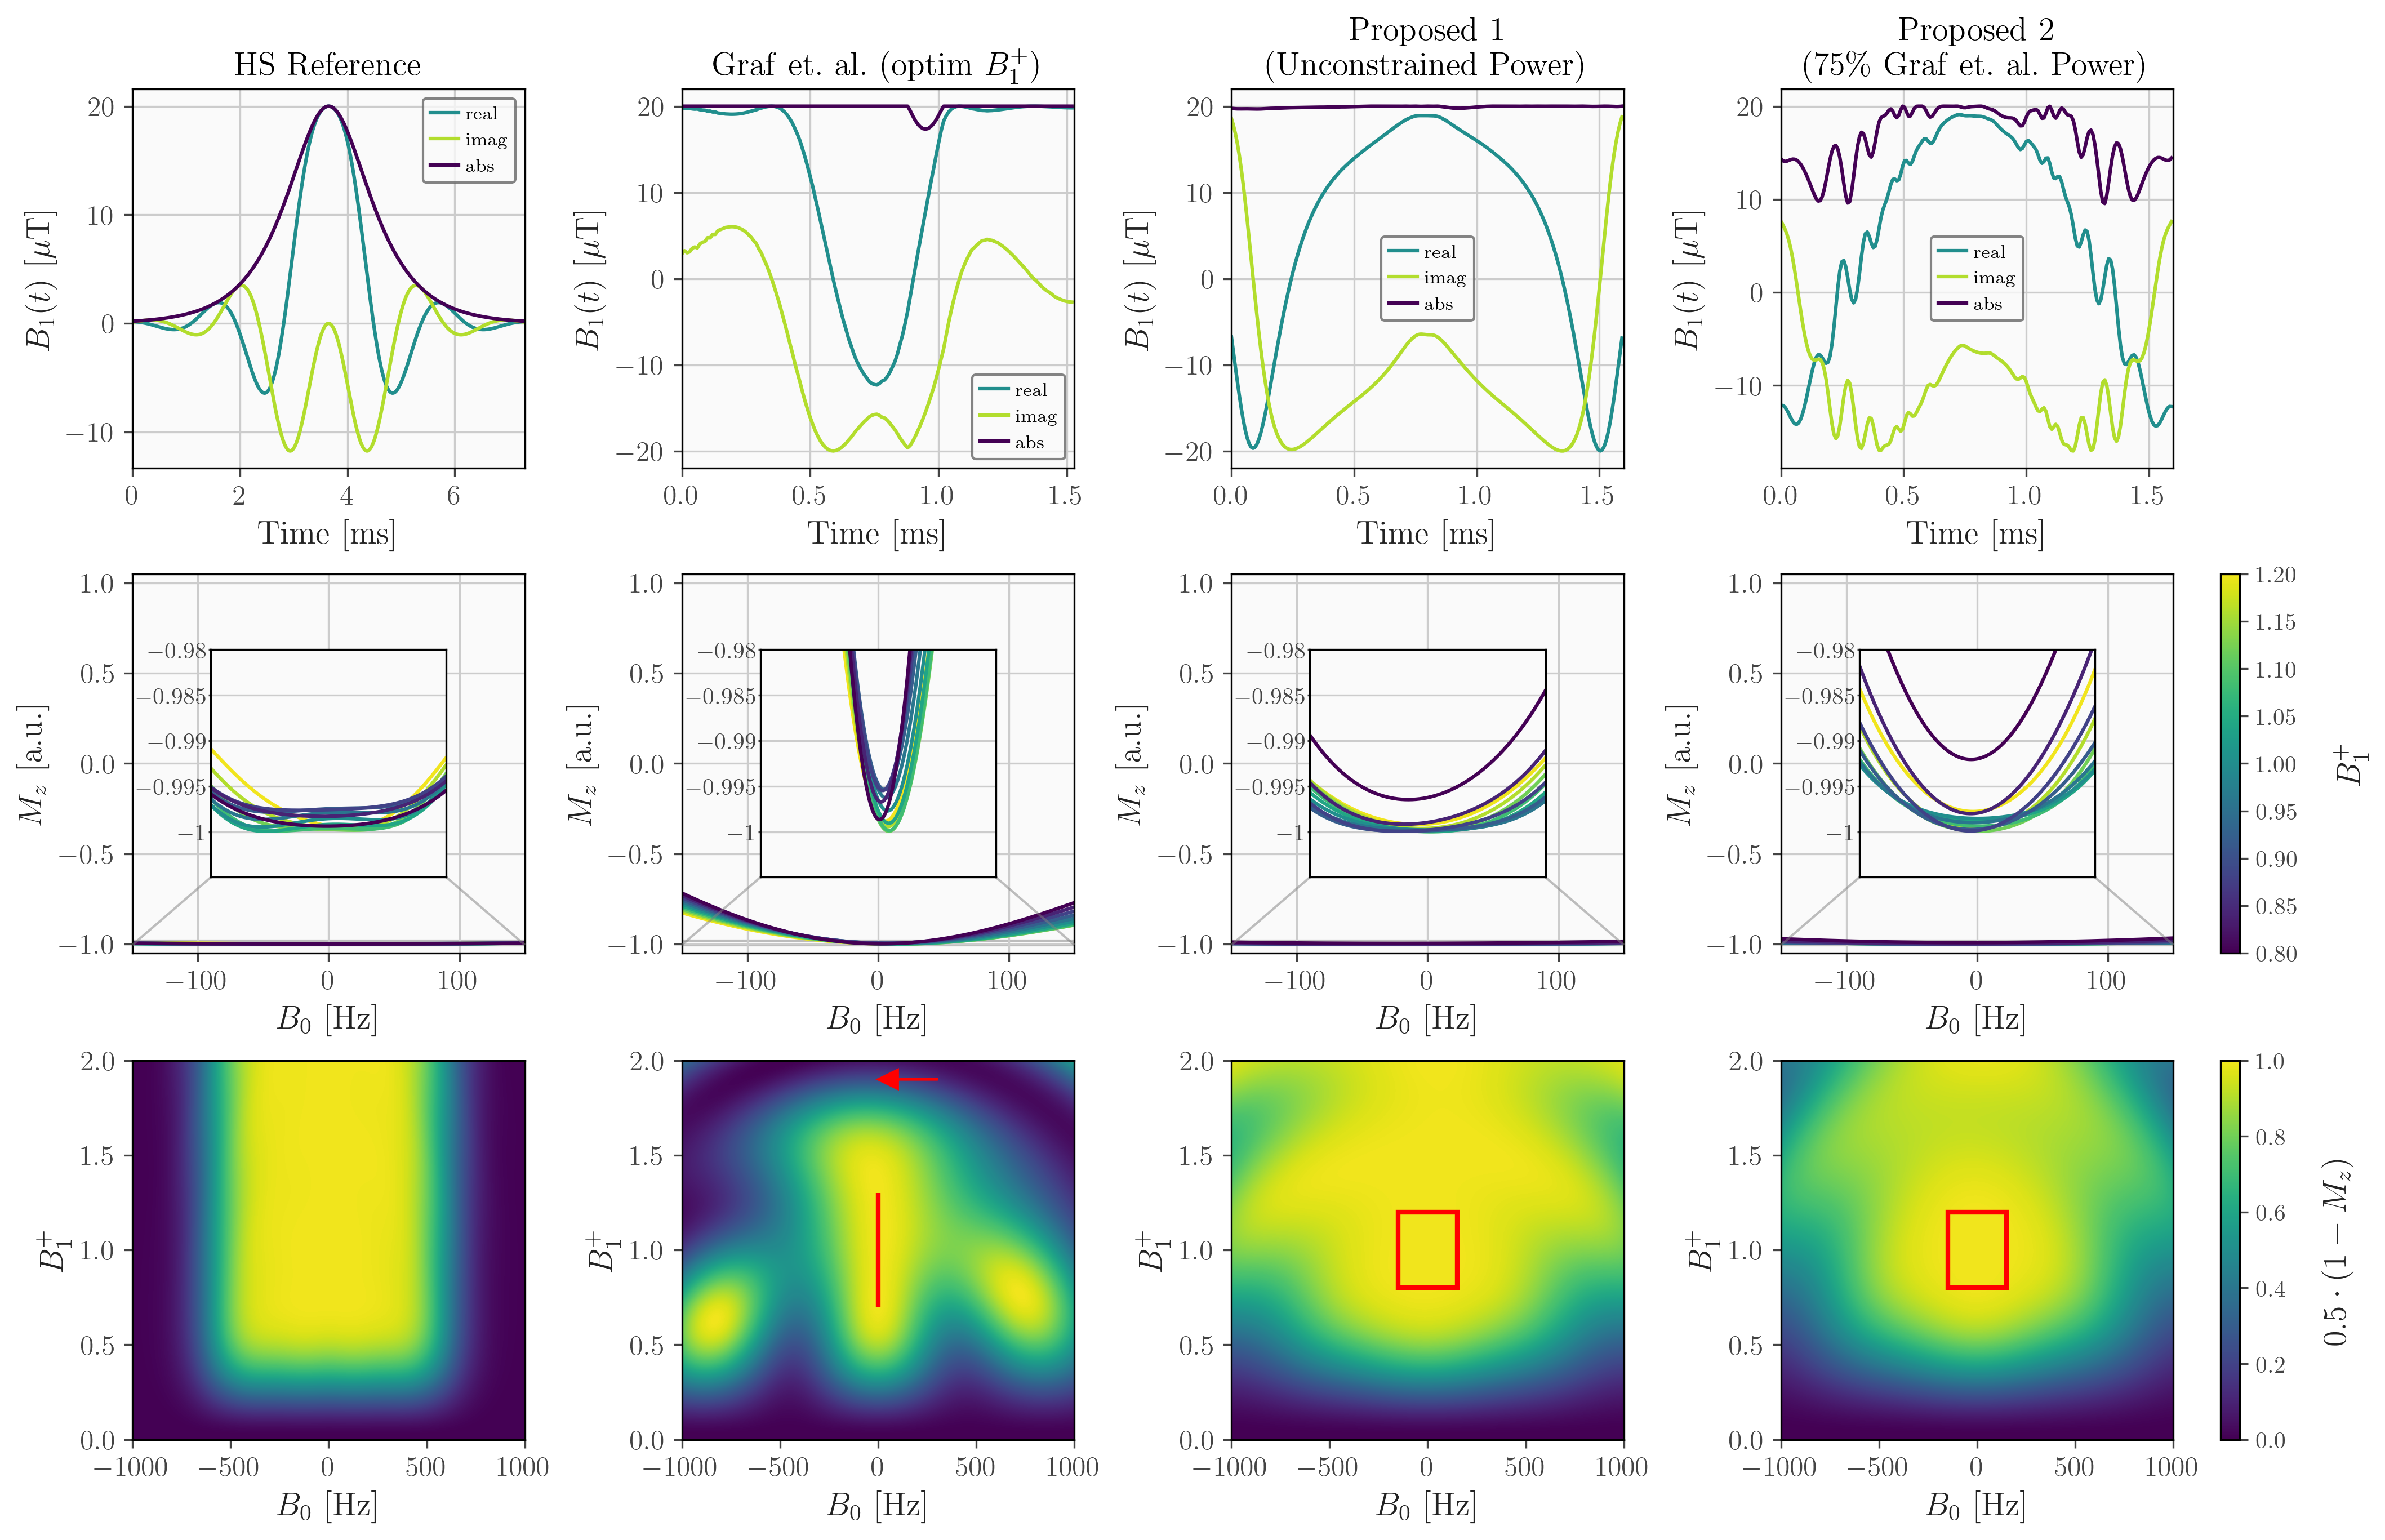

In [43]:
# data_dir = 'data/nonsel_20250313_072103' 
data_dir = 'data/nonsel_20250313_163627'
data_file = os.path.join(data_dir, 'eval_data.h5')

with h5py.File(data_file,'r') as F:
    num_pulses = F['num_pulses'][()]
    b1_design = np.array(F['b1_design'], dtype=np.float64)
    freq_design = np.array(F['freq_design'], dtype=np.float64)
    b1_eval = np.array(F['b1_eval'], dtype=np.float64)
    freq_eval = np.array(F['freq_eval'], dtype=np.float64)

    color_indices = np.linspace(0.0, 1.0, b1_design.size)
    norm = mcolors.Normalize(vmin=b1_design.min(), vmax=b1_design.max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig,ax = plt.subplots(3, num_pulses, figsize=(14,9), dpi=300, constrained_layout=True)

    for p in range(num_pulses):

        rf = np.array(F['pulse_%i'%(p)], dtype=np.complex128)
        tv = np.array(F['tv_%i'%(p)], dtype=np.float64)
        dur = F['dur_%i'%(p)][()]
        mz = np.array(F['mz_%i'%(p)], dtype=np.float64)
        mz_eval = np.transpose(np.array(F['mz_eval_%i'%(p)], dtype=np.float64), (1,0))
        show_optimized_region = F['show_optimized_region_%i'%(p)][()]
        x_corner = F['x_corner_%i'%(p)][()]
        y_corner = F['y_corner_%i'%(p)][()]
        width = F['width_%i'%(p)][()]
        height = F['height_%i'%(p)][()]
        title = F['title_%i'%(p)][()].decode("utf-8")
        legend_loc = F['legend_loc_%i'%(p)][()].decode("utf-8")

        ax[0,p].plot(tv, np.real(rf), color=colors[1], label=r'$\mathrm{real}$')
        ax[0,p].plot(tv, np.imag(rf), color=colors[2], label=r'$\mathrm{imag}$')
        ax[0,p].plot(tv, np.abs(rf), color=colors[0], label=r'$\mathrm{abs}$')
        ax[0,p].set_ylabel(r'$B_1(t)\mathrm{\ [}\mu\mathrm{T]}$')
        ax[0,p].set_xlabel(r'$\mathrm{Time\ [ms]}$')
        ax[0,p].set_xlim(0, dur)
        ax[0,p].grid()
        ax[0,p].legend(loc=legend_loc, fontsize=8, handlelength=1.5, handletextpad=0.4)
        ax[0,p].set_title(r'%s'%(title))

        for n in range(mz.shape[1]-1,-1,-1):
            ax[1,p].plot(freq_design, mz[:,n], color=cmap(color_indices[n]), label=r'$B_1^+=%.2f$'%(b1_design[n]))
        #ax[1,p].set_xlabel(r'$\mathrm{Off-Resonance\ [Hz]}$')
        ax[1,p].set_xlabel(r'$B_0\mathrm{\ [Hz]}$')
        ax[1,p].set_ylabel(r'$M_z\mathrm{\ [a.u.]}$')
        ax[1,p].set_xlim(freq_design.min(), freq_design.max())
        ax[1,p].set_ylim(-1.05, 1.05)
        ax[1,p].grid()

        inax = inset_axes(ax[1,p], width='60%', height='60%', loc='center')
        for n in range(mz.shape[1]-1,-1,-1):
            inax.plot(freq_design, mz[:,n], color=cmap(color_indices[n]), label=r'$B_1^+=%.2f$'%(b1_design[n]))
        inax.set_xlim(ax[1,p].get_xlim())
        inax.set_ylim(-1.005, -0.98)
        inax.tick_params(axis='x', labelsize=10)
        inax.tick_params(axis='y', labelsize=10, pad=0.25, length=1)
        inax.set_yticks([-1, -0.995, -0.99, -0.985, -0.98])
        inax.set_yticklabels([r'$-1$', r'$-0.995$', r'$-0.99$', r'$-0.985$', r'$-0.98$'])
        inax.set_xticks([])
        inax.set_xticklabels([])
        inax.grid()
        mark_inset(ax[1,p], inax, loc1=3, loc2=4, ec='gray', alpha=0.5)

        img = ax[2,p].imshow((1-mz_eval)/2, vmin=0.0, vmax=1.0, cmap=cmap, extent=[freq_eval.min(), freq_eval.max(), b1_eval.min(), b1_eval.max()], origin='lower')
        ax[2,p].set_aspect('auto')
        ax[2,p].set_ylabel(r'$B_1^+$')
        # ax[2,p].set_xlabel(r'$\mathrm{Off-Resonance\ [Hz]}$')
        ax[2,p].set_xlabel(r'$B_0\mathrm{\ [Hz]}$')
        if show_optimized_region:
            rect = matplotlib.patches.Rectangle((x_corner, y_corner), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax[2,p].add_patch(rect)
    
    ax[2,1].arrow(300.0, 1.9, -200.0, 0.0, head_width=0.1, head_length=100.0, fc='red', ec='red')
        
    cbar1 = fig.colorbar(sm, ax=ax[1,-1])
    cbar1.ax.tick_params(labelsize=10)
    cbar1.set_label(r'$B_1^+$', labelpad=15)

    cbar2 = fig.colorbar(img, ax=ax[2,-1])
    cbar2.ax.tick_params(labelsize=10)
    cbar2.set_label(r'$0.5\cdot (1 - M_z)$', labelpad=15)

    figfile = os.path.join(data_dir, 'figure_non-selective_%d.png'%(use_tex))
    plt.savefig(figfile)
    plt.show()



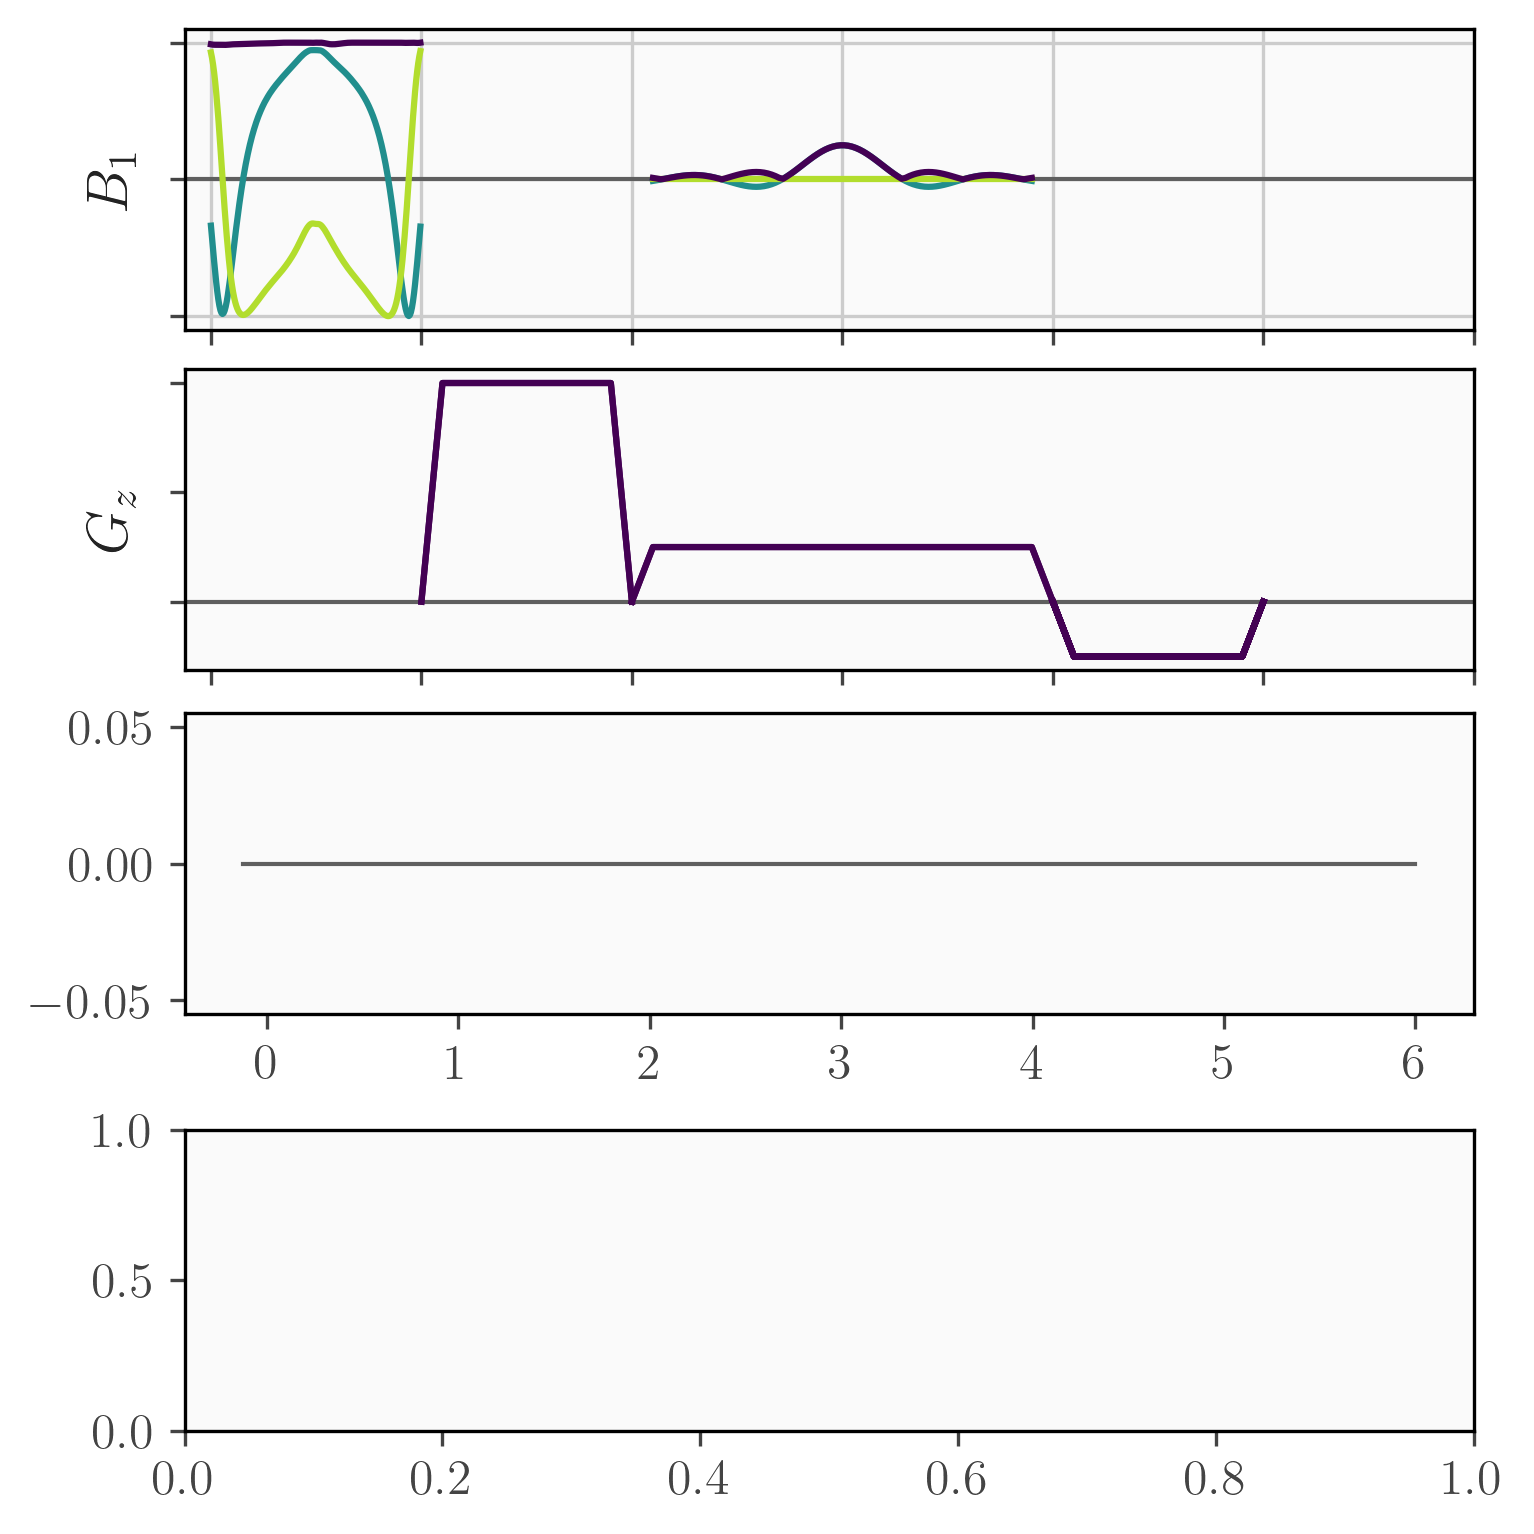

In [44]:
data_dir = 'data/nonsel_20250313_163627'
data_file = os.path.join(data_dir, 'eval_data.h5')
p = 2
with h5py.File(data_file,'r') as F:
    rf = np.array(F['pulse_%i'%(p)], dtype=np.complex128)
    # z = np.zeros((1,), dtype=rf.dtype)
    # rf = np.concatenate([z, rf, z], axis=0)
    tv = np.linspace(0, 1, rf.size, endpoint=False)

x1 = [1, 1.1, 1.9, 2.0]
y1 = [0, 1, 1, 0]

x2 = [2, 2.1, 3.9, 4.0]
y2 = [0, 0.25, 0.25, 0]

x3 = [4.0, 4.1, 4.9, 5.0]
y3 = [0, -0.25, -0.25, 0]

nsincpoints = 100
tvs = np.linspace(-np.pi, np.pi, nsincpoints)
x_exc = np.linspace(x2[1], x2[2], nsincpoints)
rf_exc = np.sinc(tvs) * 0.25 * np.max(np.abs(rf))

xmin = -0.125
xmax = 6
axis_color = '#5f5f5f'

fig,ax = plt.subplots(4, 1, figsize=(5,5), dpi=300, constrained_layout=True)

ax[0].plot([xmin, xmax], [0,0], color=axis_color, linewidth=1)
ax[0].plot(tv, np.real(rf), color=colors[1])
ax[0].plot(tv, np.imag(rf), color=colors[2])
ax[0].plot(tv, np.abs(rf), color=colors[0])
ax[0].plot(x_exc, np.real(rf_exc), color=colors[1])
ax[0].plot(x_exc, np.imag(rf_exc), color=colors[2])
ax[0].plot(x_exc, np.abs(rf_exc), color=colors[0])
# ax[0].set_xticks([])
ax[0].set_xticklabels([])
# ax[0].set_yticks([])
ax[0].set_yticklabels([])
ax[0].set_ylabel(r'$B_1$')
ax[0].set_xlim(xmin, xmax)
ax[0].grid() 

ax[1].plot([xmin, xmax], [0,0], color=axis_color, linewidth=1)
ax[1].plot(x1, y1, color=colors[0])
ax[1].plot(x2, y2, color=colors[0])
ax[1].plot(x3, y3, color=colors[0])
# ax[1].set_xticks([])
ax[1].set_xticklabels([])
# ax[1].set_yticks([])
ax[1].set_yticklabels([])
ax[1].set_ylabel(r'$G_z$')
ax[1].set_xlim(xmin, xmax)
ax[1].grid()

npe = 16 
scales = np.linspace(-1, 1, npe)
x_pe = x3 
y_pe = [0, 1, 1, 0]


ax[2].plot([xmin, xmax], [0,0], color=axis_color, linewidth=1)
for n in range(npe):
    ax[1].plot(x3, y3, color=colors[0])
ax[1].plot(x1, y1, color=colors[0])
ax[1].plot(x2, y2, color=colors[0])

# ax[1].set_xticks([])
ax[1].set_xticklabels([])
# ax[1].set_yticks([])
ax[1].set_yticklabels([])
ax[1].set_ylabel(r'$G_z$')
ax[1].set_xlim(xmin, xmax)
ax[1].grid()

# Show Results of Validation Experiment

[0.92390323 0.02371628]


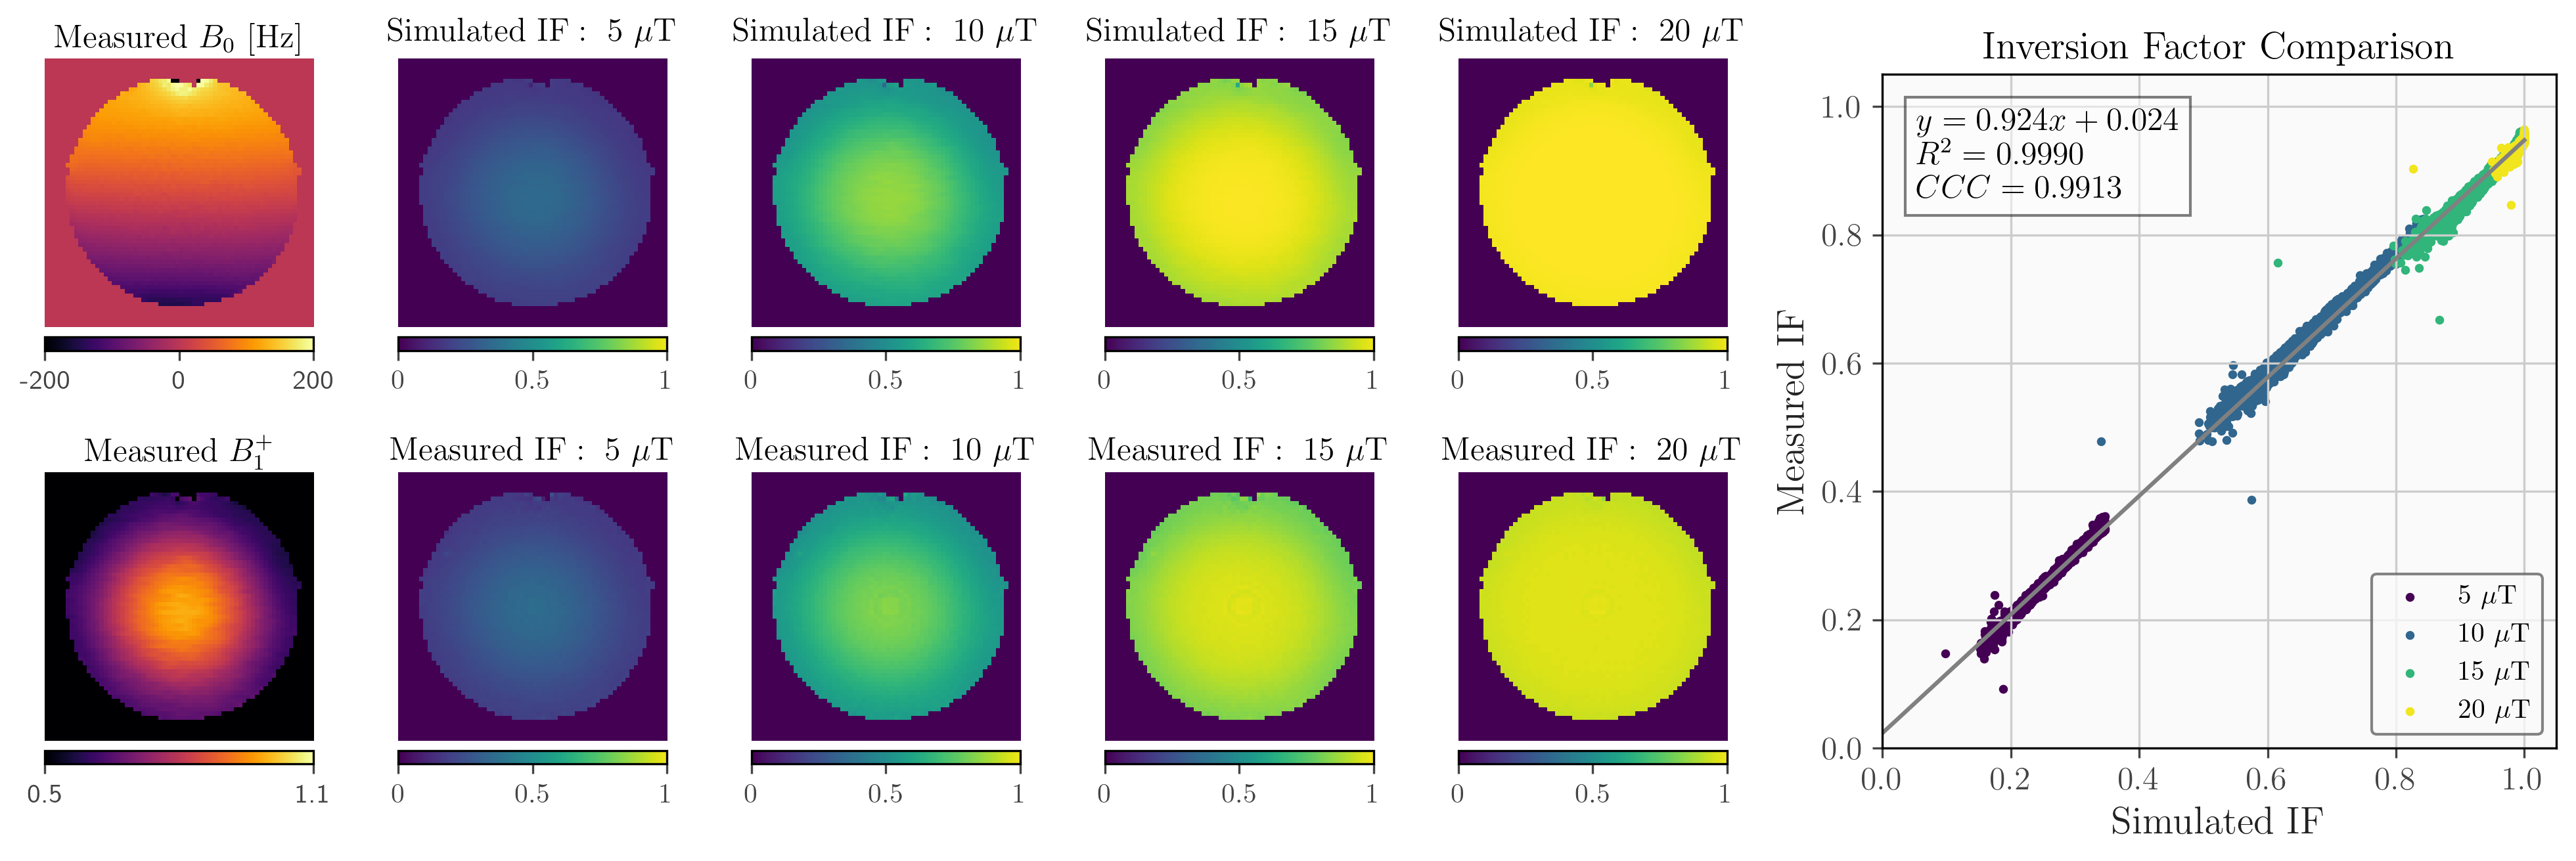

In [56]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap_field = cm.inferno

data_dir = 'data/measurements_20250319'
data_file = 'data/measurements_20250319/eval_data_meas_vs_sim.h5'
with h5py.File(data_file,'r') as F:
    B0 = np.array(F['B0'], dtype=np.float64)
    B1 = np.array(F['B1'], dtype=np.float64)
    IF = np.array(F['IF'], dtype=np.float64)
    IF_sim = np.array(F['IF_sim'], dtype=np.float64)
    mask = np.array(F['mask'], dtype=np.float64)
    inv_scales = np.array(F['inv_scales'], dtype=np.float64)

fig, ax = plt.subplots(2, 7, figsize=(13,4.25), dpi=300, constrained_layout=True)
gs = ax[0, 0].get_gridspec()
for r in range(2):
    for c in range(5,7):
        ax[r,c].remove()

fs = 12
lfs = 10

# show B0
ax_scatter = fig.add_subplot(gs[:, 5:])
ax[0,0].imshow(B0 * mask, vmin=-200.0, vmax=200.0, cmap=cmap_field)
ax[0,0].axis('off')
ax[0,0].set_title(r'$\mathrm{Measured\ }B_0\mathrm{\ [Hz]}$', fontsize=fs, pad=4)
norm = mcolors.Normalize(vmin=-200.0, vmax=200.0)
sm = cm.ScalarMappable(cmap=cmap_field, norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_ticks([-200, 0, 200])
cbar.set_ticklabels([r'-200', r'0', r'200'], fontsize=lfs)

# show B1
ax[1,0].imshow(B1 * mask, vmin=0.6, vmax=1.1, cmap=cmap_field)
ax[1,0].axis('off')
ax[1,0].set_title(r'$\mathrm{Measured\ }B_1^+$', fontsize=fs, pad=4)
b1min = 0.5
b1max = 1.1
norm = mcolors.Normalize(vmin=b1min, vmax=b1max)
sm = cm.ScalarMappable(cmap=cmap_field, norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_ticks([b1min, b1max])
cbar.set_ticklabels([r'%.1f'%(b1min), r'%.1f'%(b1max)], fontsize=lfs)

b1_peak = 20.0
for n in range(4):

    ax[0,n+1].imshow(IF_sim[:,:,n] * mask, vmin=0.0, vmax=1.0)
    ax[0,n+1].axis('off')
    ax[0,n+1].set_title(r'$\mathrm{Simulated\ IF:\ %d\ }\mu\mathrm{T}$'%(inv_scales[n] * b1_peak), fontsize=fs)
    ax[1,n+1].imshow(IF[:,:,n] * mask, vmin=0.0, vmax=1.0)
    ax[1,n+1].axis('off')
    ax[1,n+1].set_title(r'$\mathrm{Measured\ IF:\ %d\ }\mu\mathrm{T}$'%(inv_scales[n] * b1_peak), fontsize=fs, pad=4)

    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    divider = make_axes_locatable(ax[0,n+1])
    cax = divider.append_axes("bottom", size="5%", pad=0.05)  # Small padding
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels([r'$0$', r'$0.5$', r'$1$'], fontsize=lfs)
    divider = make_axes_locatable(ax[1,n+1])
    cax = divider.append_axes("bottom", size="5%", pad=0.05)  # Small padding
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels([r'$0$', r'$0.5$', r'$1$'], fontsize=lfs)

cvals = np.linspace(0, 1, 4)
for n in range(4):
    sim = IF_sim[:,:,n]
    meas = IF[:,:,n]
    sim = sim[mask > 0.0]
    meas = meas[mask > 0.0]
    ax_scatter.scatter(sim, meas, s=5, color=cmap(cvals[n]), alpha=1.0, label=r'$\mathrm{%d\ }\mu\mathrm{T}$'%(inv_scales[n] * b1_peak))
ax_scatter.grid() 
ax_scatter.set_aspect('equal')
ax_scatter.set_xlabel(r'$\mathrm{Simulated\ IF}$')
ax_scatter.set_ylabel(r'$\mathrm{Measured\ IF}$')
ax_scatter.set_xlim(0, 1.05)
ax_scatter.set_ylim(0, 1.05)
ax_scatter.set_xticks(np.arange(0, 1.2, 0.2))
ax_scatter.set_yticks(np.arange(0, 1.2, 0.2))
ax_scatter.set_title(r'$\mathrm{Inversion\ Factor\ Comparison}$')
ax_scatter.legend(loc='lower right', fontsize=lfs)

m = np.stack([mask]*4, axis=-1)
x = IF_sim[m > 0.0]
y = IF[m > 0.0]
A = np.stack([x, np.ones_like(x)], axis=-1)
beta = np.linalg.lstsq(A, y, rcond=None)[0]
print(beta)

from scipy.stats import linregress, pearsonr

# Linear regression
slope, intercept, r_value, _, _ = linregress(x, y)

# Compute predictions
y_pred = slope * x + intercept

# Compute R²
ss_total = np.sum((y - np.mean(y)) ** 2)
ss_residual = np.sum((y - y_pred) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Compute CCC
mean_x, mean_y = np.mean(x), np.mean(y)
var_x, var_y = np.var(x), np.var(y)
std_x, std_y = np.std(x), np.std(y)
pearson_corr, _ = pearsonr(x, y)

ccc = (2 * pearson_corr * std_x * std_y) / (var_x + var_y + (mean_x - mean_y) ** 2)
# Create equation text
equation_text = f"$y = {slope:.3f}x + {intercept:.3f}$\n$R^2 = {r_squared:.4f}$\n$CCC = {ccc:.4f}$"

# Add text box
ax_scatter.text(0.05, 0.95, equation_text, transform=ax_scatter.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
xx = np.array([0.0,1.0])
yy = xx*slope + intercept
ax_scatter.plot(xx, yy, color='gray')
    

fig.get_layout_engine().set(hspace=0.1) 
figfile = os.path.join(data_dir, 'figure_validation_%d.png'%(use_tex))
plt.savefig(figfile)
plt.show()